In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

import ta, pickle, json, time

# Support et Résistance

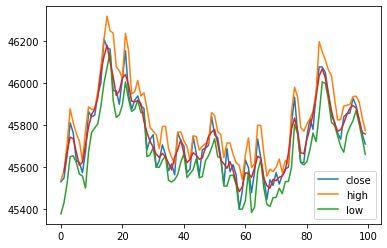

In [84]:
df = pd.read_csv("data/test.csv")
plt.plot(df.close[:100], label="close")
plt.plot(df.high[:100], label="high")
plt.plot(df.low[:100], label="low")
plt.plot(df.close.rolling(window=3, center=True).mean()[:100])
plt.legend()

## Calcul des points

In [87]:
def support_resistance(df):
    # rajoute 1 colonne support et résistance
    # -1 un support, 1 une résistance, 0 sinon
    sign = df.close.rolling(window=3, center=True).mean().diff().map(np.sign) 
    # renvoie le signe de la derivée
    df["SR"] = sign.diff(periods=-1).fillna(0) / 2
support_resistance(df)

In [103]:
start = 3713
delta = 60

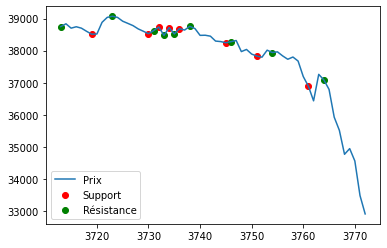

In [104]:
plt.plot(df.close[start: start+delta], label='Prix') # affiche le prix

support = df[start: start+delta].loc[df["SR"]==-1]["close"] # affiche les support en rouge
plt.scatter(support.index, support, c='r', label="Support")

resistance = df[start: start+delta].loc[df["SR"]==1]["close"] # affiche les résistance en vert
plt.scatter(resistance.index, resistance, c='g', label="Résistance")
plt.legend()

## Regression Linéaire

In [105]:
a_r, b_r = np.polyfit(resistance.index, resistance, 1, w=(resistance.index-start+1)**2)
res_line = lambda x: a_r * x + b_r

a_s, b_s = np.polyfit(support.index, support, 1, w=(support.index-start+1)**2)
sup_line = lambda x: a_s * x + b_s

x = np.linspace(start+delta/2, start+delta, 2)

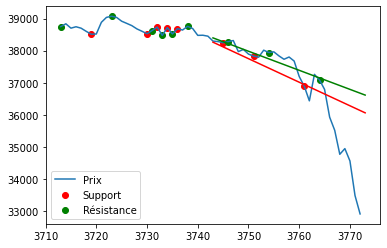

In [106]:
plt.plot(df.close[start: start+delta], label='Prix') # affiche le prix

support = df[start: start+delta].loc[df["SR"]==-1]["close"] # affiche les support en rouge
plt.scatter(support.index, support, c='r', label="Support")

resistance = df[start: start+delta].loc[df["SR"]==1]["close"] # affiche les résistance en vert
plt.scatter(resistance.index, resistance, c='g', label="Résistance")

plt.plot(x, sup_line(x), c="r")
plt.plot(x, res_line(x), c="g")

plt.legend()

## Prediction du prix
Si le prix est entre les courbes attendre  
Si le prix est au dessus de la résistance on est en survente  
Si le prix est au dessous du support on est en surachat  

In [116]:
def predict(support, resistance, start, end):
    a_s, b_s = np.polyfit(support.index, support, 1, w=(support.index-start+1)**2) 
    a_r, b_r = np.polyfit(resistance.index, resistance, 1, w=(resistance.index-start+1)**2) 
    # a_s, b_s = np.polyfit(support.index, support, 1) 
    # a_r, b_r = np.polyfit(resistance.index, resistance, 1) 
    return [a_s * end + b_s, 
            a_r * end + b_r]

## Sur tout df

In [117]:
n = 60
l = len(df)
l_support = [None] * n
l_resistance = [None] * n
for i in range(l-n):
    support = df[i:i+n].loc[df["SR"]==-1]["close"]
    resistance = df[i:i+n].loc[df["SR"]==1]["close"]
    s, r = predict(support, resistance, i, i+n+1)
    l_support.append(s)
    l_resistance.append(r)
df["Support"] = l_support
df["Resistance"] = l_resistance

In [95]:
(df.close - df.Support).argmin()

3773

In [115]:
(df.Resistance - df.Support).min()

-895.8740838231315

In [120]:
(df.Resistance - df.Support).min()

-837.5037454007979

In [108]:
(df.close - df.Support).mean()

109.42133602617662

In [119]:
df

,timestamp,open,high,low,close,volume,SR,Support,Resistance
0,2021-05-16 22:02:00,45377.19,45539.00,45377.19,45530.62,130.561983,0.0,45468.332478,45559.697872
1,2021-05-16 22:03:00,45528.98,45581.65,45430.65,45548.49,182.492948,0.0,45468.332478,45559.697872
2,2021-05-16 22:04:00,45548.49,45709.11,45522.11,45654.36,151.296726,0.0,45468.332478,45559.697872
3,2021-05-16 22:05:00,45654.36,45878.14,45650.00,45812.14,213.061258,1.0,45468.332478,45559.697872
4,2021-05-16 22:06:00,45812.14,45812.15,45654.85,45763.92,146.018679,0.0,45468.332478,45559.697872
...,...,...,...,...,...,...,...,...,...
8636,2021-05-22 21:58:00,38050.71,38139.78,38028.71,38137.65,31.582959,0.0,38042.103890,38347.291515
8637,2021-05-22 21:59:00,38137.66,38172.95,38086.52,38153.77,34.298543,0.0,38047.039371,38365.714603
8638,2021-05-22 22:00:00,38153.91,38300.00,38153.77,38287.57,84.791436,0.0,38052.175035,38384.716177
8639,2021-05-22 22:01:00,38287.58,38304.99,38218.06,38236.11,69.558038,0.0,38057.515816,38404.313941


In [118]:
df["Support"].fillna(method='backfill', inplace=True)
df["Resistance"].fillna(method='backfill', inplace=True)